In [72]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
from scipy.ndimage import rotate as rtim
import albumentations as A

In [440]:
def read_img(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def save_image(image, output_path = "generated_dataset/images"):
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def display_image(image, title="Image"):
    """
    Display an image using matplotlib. Rembember to use plt.show() to display the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.show()


plot bounding box để check

In [443]:
# đầu vào định dạng yolo
def plot_BB(image_path, coord_path):
    image = read_img(image_path)

    with open(coord_path, "r") as f:
        coordinates = [line.strip().split() for line in f.readlines()]

    plt.imshow(image)
    for coord in coordinates:
        # Split the coordinates
        label, x_cen, y_cen, w, h = map(float, coord)
        x = x_cen - w / 2
        y = y_cen - h / 2
        # Scale the coordinates to the image dimensions
        x *= image.shape[1]
        y *= image.shape[0]
        w *= image.shape[1]
        h *= image.shape[0]
        # Convert coordinates to integers
        x, y, w, h = map(int, (x, y, w, h))

        rect_box = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=1)
        plt.gca().add_patch(rect_box)

    plt.show()

test đọc, display ảnh

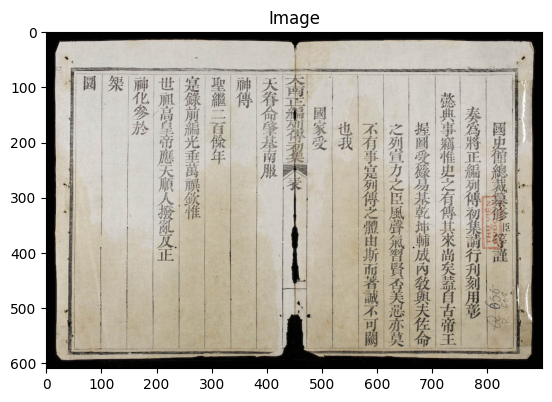

In [441]:
img_gt = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"   #path to the groundtruth image
img = read_img(img_gt)
display_image(img)

sinh thêm dataset

scale

In [458]:
def scale_labels(labels):
    x, y, w, h = map(float, labels)
    scaled_x = x
    scaled_y = y
    scaled_w = w
    scaled_h = h
    scaled_labels = [scaled_x, scaled_y, scaled_w, scaled_h]
    return scaled_labels

def scale_image(image, scale_x, scale_y, interpolation=cv2.INTER_CUBIC):
    width = int(image.shape[1] * scale_x)
    height = int(image.shape[0] * scale_y)
    scaled_image = cv2.resize(image, (width, height), interpolation=interpolation)
    return scaled_image

def handle_scale_labels_file(in_file, out_file):
    with open(out_file, "w") as out:
        pass
    with open(in_file, "r") as f, open(out_file, "w") as out:
        for line in f.readlines():
            coord = list(map(float, line.strip().split()))
            coord[0] = int(coord[0])
            out.write(f"{coord[0]} {coord[1]:.6f} {coord[2]:.6f} {coord[3]:.6f} {coord[4]:.6f}\n")


sinh scaled dataset

In [104]:
# def handle_scale_convert(images_folder, labels_folder):
#     out_folder = "generated_dataset/"
#     out_images = out_folder + "images/val/"
#     out_labels = out_folder + "labels/val/"

#     for filename in os.listdir(images_folder):
#         if filename.endswith(".jpg"):
#             scale_x = round(random.uniform(0.5, 2), 1)
#             scale_y = round(random.uniform(0.5, 2), 1)   
#             image_file = os.path.join(images_folder, filename)
#             out_img_name = out_images + "__scale__" + filename
#             image = read_img(image_file)
#             scaled_image = scale_image(image, scale_x, scale_y)
#             save_image(scaled_image, out_img_name)


#     for filename in os.listdir(labels_folder):
#         if filename.endswith(".txt"):
#             label_file = os.path.join(labels_folder, filename)
#             out_label_name = out_labels + "__scale__" + filename
#             handle_scale_labels_file(label_file, out_label_name)

# handle_scale_convert("wb_localization_dataset/images/val", "wb_localization_dataset/labels/val")

variant: rotate, flip, add noise, blur, bright

In [473]:
def multi_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='yolo')
    transform = A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.5),
        A.GaussNoise(p=0.5),
        A.Rotate(limit=30),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, elementwise=True, p=0.5),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes)

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    return transformed_img, transformed_bboxes

test variant

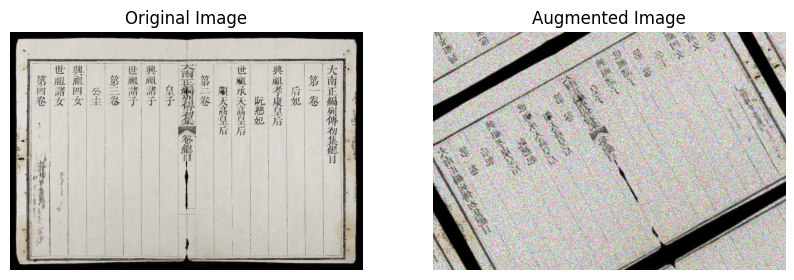

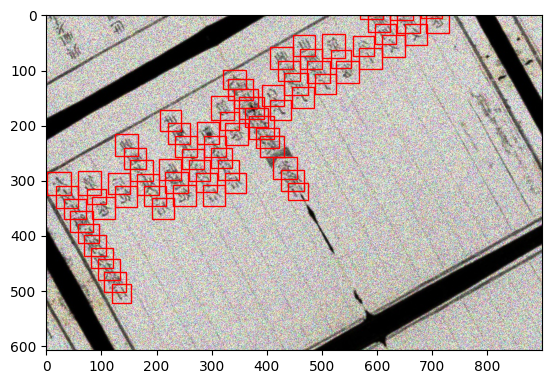

In [474]:
inf_name = "generated_dataset/labels/train/__scale__nlvnpf-0137-01-006.txt"
outf_name = "generated_dataset/labels/test1.txt"
outf_img = "generated_dataset/images/test1.jpg"

img = read_img("wb_localization_dataset/images/train/nlvnpf-0137-01-006.jpg")
with open(inf_name, "r") as inf, open(outf_name, "w") as outf:
    bboxes = []
    for line in inf.readlines():
        values = line.strip().split()
        x_center, y_center, width, height = map(float, values[1:5])
        class_id = int(values[0])
        bboxes.append([x_center, y_center, width, height, class_id])
    agm_img, agm_bbox = multi_transform(img, bboxes)
    for bbox in agm_bbox:
        outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    save_image(agm_img, outf_img)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(agm_img)
    axes[1].set_title('Augmented Image')
    axes[1].axis('off')
    plt.show()

plot_BB(outf_img, outf_name)
    

sinh variant dataset

In [479]:
def handle_variant(in_img_path, in_lb_path, out_img_path, out_lb_path):
    img = read_img(in_img_path)

    with open(in_lb_path, "r") as inf, open(out_lb_path, "w") as outf:
        bboxes = []
        for line in inf.readlines():
            values = line.strip().split()
            x_center, y_center, width, height = map(float, values[1:5])
            class_id = int(values[0])
            bboxes.append([x_center, y_center, width, height, class_id])
        agm_img, agm_bbox = multi_transform(img, bboxes)
        for bbox in agm_bbox:
            outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        save_image(agm_img, out_img_path)

def handle_variant_convert(images_folder, labels_folder, type="train/"):
    out_folder = "generated_dataset/"
    f_images = out_folder + "images/" + type
    f_labels = out_folder + "labels/" + type

    for fileImgName in os.listdir(images_folder):
        if fileImgName.endswith(".jpg"):  
            general_name = fileImgName.split('.')[0]
            out_img_name = f_images + "__variant__" + fileImgName
            in_img_name = images_folder + "/" + fileImgName
            print(out_img_name)

            fileLbName = general_name + ".txt"
            out_label_name = f_labels + "__variant__" + fileLbName
            in_label_name = labels_folder + "/" + fileLbName
            print(out_label_name)

            handle_variant(in_img_name, in_label_name, out_img_name, out_label_name)

handle_variant_convert("wb_localization_dataset/images/val", "wb_localization_dataset/labels/val", "val/")
#handle_variant_convert("wb_localization_dataset/images/train", "wb_localization_dataset/labels/train", "train/")

generated_dataset/images/val/__variant__nlvnpf-0137-01-045.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-045.txt
generated_dataset/images/val/__variant__nlvnpf-0137-01-046.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-046.txt
generated_dataset/images/val/__variant__nlvnpf-0137-01-047.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-047.txt
generated_dataset/images/val/__variant__nlvnpf-0137-01-048.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-048.txt
generated_dataset/images/val/__variant__nlvnpf-0137-01-049.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-049.txt
generated_dataset/images/val/__variant__nlvnpf-0137-01-050.jpg
generated_dataset/labels/val/__variant__nlvnpf-0137-01-050.txt
generated_dataset/images/val/__variant__nlvnpf-0140-01-016.jpg
generated_dataset/labels/val/__variant__nlvnpf-0140-01-016.txt
generated_dataset/images/val/__variant__nlvnpf-0140-01-017.jpg
generated_dataset/labels/val/__variant__nlvnpf-0140-01-